# Summary

# Intro

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import common
common.configure_logging(level='debug')

DEBUG:root:Done configuring logging!


In [3]:
from biodata import *

/home/kimlab1/strokach/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
%matplotlib inline

# Functions

# Load data

## Cell lines

In [5]:
cell_info = pd.read_csv(
    '../downloads/challenge_data/sanger_molecular_data/'
    'cell_info.csv/cell_info.csv',
    sep=',',
)

In [6]:
cell_info.head(2)

,Sanger.Name,CCLE.Name,Alternative.Name,Disease.Area,Tissue..General.,COSMIC
0,22RV1,22RV1_PROSTATE,22RV1,Urology,male genital system,924100
1,647-V,647V_URINARY_TRACT,647V,Urology,urinary tract,906797


In [7]:
cell_info = cell_info.rename(columns={
    'Sanger.Name': 'cell_line',
    'CCLE.Name': 'cell_line_ccle',
    'Alternative.Name': 'cell_line_alternative',
    'Disease.Area': 'cell_line_disease_area',
    'Tissue..General.': 'cell_line_tissue',
    'COSMIC': 'cell_line_cosmic',
})

In [8]:
cell_info.head(2)

,cell_line,cell_line_ccle,cell_line_alternative,cell_line_disease_area,cell_line_tissue,cell_line_cosmic
0,22RV1,22RV1_PROSTATE,22RV1,Urology,male genital system,924100
1,647-V,647V_URINARY_TRACT,647V,Urology,urinary tract,906797


In [9]:
cell_line_to_disease_area = {
    a: b for (a, b) in cell_info[['cell_line', 'cell_line_disease_area']].values
}

In [10]:
cell_line_to_tissue = {
    a: b for (a, b) in cell_info[['cell_line', 'cell_line_tissue']].values
}

## CNVs

In [11]:
cnv_segment = pd.read_csv(
    '../downloads/challenge_data/sanger_molecular_data/cnv/'
    'cnv_segment.csv/cnv_segment.csv',
    sep=',', low_memory=False, na_values=['-'],
)

In [12]:
display(cnv_segment.head(2))
print(cnv_segment.shape)

,cell_line_name,sample_id,SNPstart,SNPend,chr_38,startpos_38,endpos_38,chr_37,startpos_37,endpos_37,minorCN,totalCN
0,NCI-H522,905944,1,14597,1,61736,25256851,1,61736,25583342,1,3
1,NCI-H522,905944,14598,14626,1,25266638,25320456,1,25593129,25646947,0,0


(31662, 12)


In [13]:
cnv_gene = pd.read_csv(
    '../downloads/challenge_data/sanger_molecular_data/cnv/'
    'cnv_gene.csv/cnv_gene.csv',
    sep=',', low_memory=False, na_values=['-'],
)

In [14]:
display(cnv_gene.head(2))
print(cnv_gene.shape)

,cell_line_name,gene,chr_GRCh38,gene_start_GRCh38,gene_end_GRCh38,max_cn_GRCh38,min_cn_GRCh38,zygosity_GRCh38,disruption_status_GRCh38,chr_GRCh37,gene_start_GRCh37,gene_end_GRCh37,max_cn_GRCh37,min_cn_GRCh37,zygosity_GRCh37,disruption_status_GRCh37
0,22RV1,39340,1,86880690,86914111,2,2,H,NaN,1,87346373,87379794,2,2,H,NaN
1,647-V,39340,1,86880690,86914111,-1,-1,NaN,NaN,1,87346373,87379794,3,3,H,NaN


(2478430, 16)


In [15]:
cnv_gene[['cell_line_name', 'gene']].drop_duplicates().shape

(2478430, 2)

## CSS

In [16]:
css = pd.read_sql_query("""\
SELECT c, avg(synergy_score) synergy_score
FROM az_dream_2015.ALL_TRAINING_DATA_WSYNERGY
where synergy_score is not null
group by c;
""", sa.create_engine('mysql://strokach:@192.168.6.19:3306/az_dream_2015'))

In [17]:
css = css.set_index('c')['synergy_score']

In [18]:
css.head()

c
22RV1       -8.601674
647-V       13.834063
A549        21.671942
BFTC-905    21.839952
BT-20       22.283808
Name: synergy_score, dtype: float64

## Cancer gene census

In [19]:
engine = sa.create_engine('mysql://strokach:@192.168.6.19:3306/cosmic')
cancer_gene_census = pd.read_sql_table('cancer_gene_census', engine)

In [20]:
cancer_gene_census.head(2)

,gene_symbol,name,entrez_geneid,genome_location,chr_band,somatic,germline,tumour_types_somatic,tumour_types_germline,cancer_syndrome,tissue_type,molecular_genetics,mutation_types,translocation_partner,other_germline_mut,other_syndrome,synonyms
0,ABI1,abl-interactor 1,10006,10:26748570-26860863,10p11.2,yes,None,AML,None,None,L,Dom,T,KMT2A,None,None,"ABI1,E3B1,ABI-1,SSH3BP1,10006"
1,ABL1,v-abl Abelson murine leukemia viral oncogene h...,25,9:130835447-130885683,9q34.1,yes,None,"CML, ALL, T-ALL",None,None,L,Dom,"T, Mis","BCR, ETV6, NUP214",None,None,"ABL1,p150,ABL,c-ABL,JTK7,bcr/abl,v-abl,P00519,..."


In [21]:
print("Total number of genes:", len(set(cnv_gene['gene'])))
print("Number of cancer gene census genes:", len(set(cancer_gene_census['gene_symbol'])))
print("Overlap:", len(set(cnv_gene['gene']) & set(cancer_gene_census['gene_symbol'])))

Total number of genes: 29158
Number of cancer gene census genes: 571
Overlap: 551


In [22]:
cgs_genes = list(set(cnv_gene['gene']) & set(cancer_gene_census['gene_symbol']))

## Target genes

In [23]:
engine = sa.create_engine('mysql://strokach:@192.168.6.19:3306/az_dream_2015')
drug_to_hgnc_target = pd.read_sql_table('drug_to_hgnc_target', engine)
drug_to_hgnc_target.head(2)

,drug,hgnc_name
0,ADAM17,ADAM17
1,AKT,AKT1


In [24]:
print("Total number of genes:", len(set(cnv_gene['gene'])))
print("Number of cancer gene census genes:", len(set(drug_to_hgnc_target['hgnc_name'])))
print("Overlap:", len(set(cnv_gene['gene']) & set(drug_to_hgnc_target['hgnc_name'])))

Total number of genes: 29158
Number of cancer gene census genes: 222
Overlap: 221


In [25]:
target_genes = list(set(cnv_gene['gene']) & set(drug_to_hgnc_target['hgnc_name']))

# Process CNV (gene level)

- `zygosity_GRCh37` is "-" when both `max_cn_GRCh37` and `min_cn_GRCh37` are "-1".
- `zygosity_GRCh37` is "0" when both `max_cn_GRCh37` and `min_cn_GRCh37` are "0".

In [26]:
cnv_gene['zygosity_GRCh37'].drop_duplicates()

0          H
2          L
14696      0
51330    NaN
Name: zygosity_GRCh37, dtype: object

In [27]:
cnv_gene = cnv_gene.rename(
    columns={
        'cell_line_name': 'cell_line',
        'max_cn_GRCh37': 'max_cn',
        'min_cn_GRCh37': 'min_cn',
    })

if 'cell_line_tissue' not in cnv_gene:
    len_before = len(cnv_gene)
    cnv_gene = cnv_gene.merge(cell_info, on='cell_line')
    assert len(cnv_gene) == len_before

In [28]:
# Transform data to extract some usable features
features = [
    'max_cn', 'min_cn', 
    'zygosity_1', 'zygosity_2', 
    'disruption_status',  
    'delta_cn',
]

def classify_zygosity(z):
    if z == 'H':
        return (1, 0)
    elif z == 'L':
        return (0, 1)
    elif z == '0':
        return (0, 0)
    else:
        return (np.nan, np.nan)

# Copy numbers
cnv_gene.loc[cnv_gene['max_cn'] == -1, 'max_cn'] = np.nan
cnv_gene.loc[cnv_gene['min_cn'] == -1, 'min_cn'] = np.nan
cnv_gene['delta_cn'] = cnv_gene['max_cn'] - cnv_gene['min_cn']

# Zygosity
cnv_gene['zygosity_1'], cnv_gene['zygosity_2'] = list(zip(
    *cnv_gene['zygosity_GRCh37'].apply(classify_zygosity)
))

# Gene disruption
cnv_gene['disruption_status'] = cnv_gene['disruption_status_GRCh37'].apply(lambda x: int(x == 'D'))

In [29]:
cnv_gene.tail(2)

,cell_line,gene,chr_GRCh38,gene_start_GRCh38,gene_end_GRCh38,max_cn_GRCh38,min_cn_GRCh38,zygosity_GRCh38,disruption_status_GRCh38,chr_GRCh37,gene_start_GRCh37,gene_end_GRCh37,max_cn,min_cn,zygosity_GRCh37,disruption_status_GRCh37,cell_line_ccle,cell_line_alternative,cell_line_disease_area,cell_line_tissue,cell_line_cosmic,delta_cn,zygosity_1,zygosity_2,disruption_status
2478428,VM-CUB-1,mir-223,X,66018870,66018979,1,1,L,NaN,X,65238712,65238821,1,1,L,NaN,VMCUB1_URINARY_TRACT,VMCUB1,Urology,urinary tract,909780,0,0,1,0
2478429,VM-CUB-1,mir-424,X,134546614,134546711,1,1,L,NaN,X,133680644,133680741,1,1,L,NaN,VMCUB1_URINARY_TRACT,VMCUB1,Urology,urinary tract,909780,0,0,1,0


In [30]:
# Validate that we haven't done anything too bad...
assert not (cnv_gene['max_cn'] == cnv_gene['min_cn']).all()

In [31]:
cnv_gene['delta_cn'].sum()

13073.0

## Create a pivot table for every feature of importance

In [32]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0, verbose=1)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

feature_dfs = dict()
for feature in features:
    df = (
        cnv_gene
        .pivot(index='cell_line', columns='gene', values=feature)
        .dropna(axis=1, how='all')
        .sort_index()
    )
    X = df.values
    X = imp.fit_transform(X)
    # X = scaler.fit_transform(X)
    feature_dfs[feature] = pd.DataFrame(X, index=df.index, columns=df.columns)
    assert len(feature_dfs[feature]) == 85 # make sure we have at least one gene for all cell lines
    print('{}: {}'.format(feature, feature_dfs[feature].shape))

max_cn: (85, 29124)
min_cn: (85, 29124)
zygosity_1: (85, 29124)
zygosity_2: (85, 29124)
disruption_status: (85, 29158)
delta_cn: (85, 29124)


## Choose best metric for pairwise distances

In [33]:
metrics = [
    'euclidean',
    'minkowski', 
    'cityblock',
    'seuclidean', 
    'sqeuclidean',
    'cosine',
    'correlation',
    'hamming',
    'jaccard',
    'chebyshev',
    'canberra',
    'braycurtis',
    # 'mahalanobis',
    'yule',
    'matching',
    'dice',
    'kulsinski',
    'rogerstanimoto',
    'russellrao',
    'sokalmichener',
    'sokalsneath',
    # 'wminkowski',
]

In [34]:
index = feature_dfs['min_cn'].index.copy()
index.names = ['c_1']  # cell 1
columns=feature_dfs['min_cn'].index.copy()
columns.names = ['c_2']  # cell 2

In [35]:
results_all = {}
results_best = {}

output = {}
output = {}

groups = [
    # CN
    ('max_cn', ), 
    ('min_cn', ),
    ('max_cn', 'min_cn'),
    # Zygosity
    ('zygosity_1', 'zygosity_2'),
    ('zygosity_1', 'zygosity_2', 'delta_cn'),
    ('disruption_status', ),
    # All together
    ('zygosity_1', 'zygosity_2', 'disruption_status', ),
    ('min_cn', 'zygosity_1', 'zygosity_2', 'disruption_status', ),
    # Binarize copy number data
    ('delta_cn', ), 
]
groups = [
    ('min_cn', ),
    ('delta_cn', ),
    ('zygosity_1', 'zygosity_2'),
    ('disruption_status', ),
]

for group in groups:
    for gene_subset in [None, 'cgs', 'target', 'cgs_plus_target']:
        # All genes or only cancer gene sensus genes
        if gene_subset is None:
            all_features = np.hstack([feature_dfs[v].values for v in group])
        elif gene_subset == 'cgs':
            all_features = np.hstack([feature_dfs[v][cgs_genes].values for v in group])
        elif gene_subset == 'target':
            all_features = np.hstack([feature_dfs[v][target_genes].values for v in group])
        elif gene_subset == 'cgs_plus_target':
            cgs_plus_target_genes = list(set(cgs_genes) | set(target_genes))
            all_features = np.hstack([feature_dfs[v][cgs_plus_target_genes].values for v in group])
        else:
            raise Exception
        # Get a correlation score using all available metrics
        results = []
        for metric in metrics:
            try:
                PW = sp.spatial.distance.squareform(sp.spatial.distance.pdist(all_features, metric=metric))
            except ValueError:
                print("Skipping metric {}".format(metric))
            PW = pd.DataFrame(PW, index=index, columns=columns).unstack().reset_index()
            PW['synergy_score_x'] = PW['c_1'].map(css)
            PW['synergy_score_y'] = PW['c_2'].map(css)
            PW['synergy_score_diff'] = (PW['synergy_score_y'] - PW['synergy_score_x'])
            # Pearson
            P_r, P_p = sp.stats.pearsonr(PW['synergy_score_diff'].abs(), PW[0])
            # Spearman
            S = sp.stats.spearmanr(PW['synergy_score_diff'].abs(), PW[0])
            S_r, S_p = S.correlation, S.pvalue
            results.append((metric, P_r, S_r, PW))
        results.sort(key=lambda x: np.nansum([abs(x[1]), abs(x[2])]), reverse=True)
        # Save best result
        metric, P_r, S_r, PW = results[0]
        results_best[(group, gene_subset)] = {
            'metric': metric,
            'P_r': P_r,
            'S_r': S_r,
            'df': PW,
        }
        # Stats for all metrics
        df = pd.DataFrame([r[:3] for r in results], columns=['metric', 'pearson_r', 'spearman_r'])
        results_all[group] = df

In [36]:
results_best_df = pd.DataFrame(results_best).T.reset_index().rename(
    columns={'index': 'group'}
)
results_best_df['subset'] = results_best_df['group'].apply(lambda x: x[1])
results_best_df['group'] = results_best_df['group'].apply(lambda x: '|'.join(x[0]))

In [37]:
results_best_df['group'] = results_best_df['group']
results_best_df['abs'] = results_best_df[['P_r', 'S_r']].apply(lambda x: np.mean(np.abs(x)), axis=1)
results_best_df.sort_values('abs', ascending=False, inplace=True)
display(results_best_df[results_best_df['subset'].isnull()])
display(results_best_df[results_best_df['subset'] == 'cgs'])
display(results_best_df[results_best_df['subset'] == 'target'])
display(results_best_df[results_best_df['subset'] == 'cgs_plus_target'])

,group,P_r,S_r,df,metric,subset,abs
4,zygosity_1|zygosity_2,0.0819968,0.186759,c_2 c_1 0 synergy_sco...,chebyshev,None,0.134378
8,disruption_status,0.0819968,0.186759,c_2 c_1 0 synergy_sco...,chebyshev,None,0.134378
6,min_cn,-0.132518,-0.0653529,c_2 c_1 0 syne...,cosine,None,0.098936
15,delta_cn,-0.112771,-0.0476834,c_2 c_1 0 syne...,matching,None,0.080227


,group,P_r,S_r,df,metric,subset,abs
5,zygosity_1|zygosity_2,0.0819968,0.186759,c_2 c_1 0 synergy_sco...,chebyshev,cgs,0.134378
11,disruption_status,0.0821535,0.156896,c_2 c_1 0 synergy_sco...,chebyshev,cgs,0.119525
12,delta_cn,-0.118004,-0.103122,c_2 c_1 0 synergy_sc...,cityblock,cgs,0.110563
9,min_cn,-0.141884,-0.0716138,c_2 c_1 0 syne...,cosine,cgs,0.106749


,group,P_r,S_r,df,metric,subset,abs
2,zygosity_1|zygosity_2,-0.140413,-0.129803,c_2 c_1 0 syn...,seuclidean,target,0.135108
0,delta_cn,0.0821635,0.147619,c_2 c_1 0 syne...,kulsinski,target,0.114891
14,disruption_status,0.0822934,0.123126,c_2 c_1 0 syne...,kulsinski,target,0.102710
1,min_cn,0.0284476,0.133843,c_2 c_1 0 syn...,seuclidean,target,0.081146


,group,P_r,S_r,df,metric,subset,abs
13,zygosity_1|zygosity_2,0.0819968,0.186759,c_2 c_1 0 synergy_sco...,chebyshev,cgs_plus_target,0.134378
7,disruption_status,0.0825237,0.17225,c_2 c_1 0 synergy_sco...,chebyshev,cgs_plus_target,0.127387
3,delta_cn,-0.12867,-0.107216,c_2 c_1 0 synergy_sc...,cityblock,cgs_plus_target,0.117943
10,min_cn,-0.121744,-0.0582373,c_2 c_1 0 syne...,cosine,cgs_plus_target,0.089991


# Save

In [38]:
import csv2sql
db = csv2sql.DataFrameToMySQL(
    'mysql://strokach:@192.168.6.19:3306/az_dream_2015_features', 
    'cnv', 
    '192.168.6.8', 
    echo=False
)

In [39]:
import csv2sql.g2d

## gc

In [40]:
cnv_gene_tmp = cnv_gene.rename(columns={'cell_line': 'c', 'gene': 'g'})

In [41]:
cnv_gene_tmp.head(2)

,c,g,chr_GRCh38,gene_start_GRCh38,gene_end_GRCh38,max_cn_GRCh38,min_cn_GRCh38,zygosity_GRCh38,disruption_status_GRCh38,chr_GRCh37,gene_start_GRCh37,gene_end_GRCh37,max_cn,min_cn,zygosity_GRCh37,disruption_status_GRCh37,cell_line_ccle,cell_line_alternative,cell_line_disease_area,cell_line_tissue,cell_line_cosmic,delta_cn,zygosity_1,zygosity_2,disruption_status
0,22RV1,39340,1,86880690,86914111,2,2,H,NaN,1,87346373,87379794,2,2,H,NaN,22RV1_PROSTATE,22RV1,Urology,male genital system,924100,0,1,0,0
1,22RV1,A1BG,19,58347022,58353437,-1,-1,NaN,NaN,19,58858388,58864803,2,2,H,NaN,22RV1_PROSTATE,22RV1,Urology,male genital system,924100,0,1,0,0


In [42]:
cnv_gbgc = (
    cnv_gene_tmp
    [['g', 'c', 'min_cn', 'delta_cn', 'zygosity_1', 'zygosity_2', 'disruption_status']]
    .rename(columns=lambda x: (x + '_gbgc') if x not in ['g', 'c'] else x)
    .rename(columns={'disruption_status_gbgc': 'disruption_status_gbgc_max'})
)

In [43]:
cnv_gbgc.head()

,g,c,min_cn_gbgc,delta_cn_gbgc,zygosity_1_gbgc,zygosity_2_gbgc,disruption_status_gbgc_max
0,39340,22RV1,2,0,1,0,0
1,A1BG,22RV1,2,0,1,0,0
2,A1CF,22RV1,2,0,1,0,0
3,A1CF_ENST00000282641,22RV1,2,0,1,0,0
4,A1CF_ENST00000373995,22RV1,2,0,1,0,0


In [44]:
db.import_table(
    cnv_gbgc,
    'cnv_gbgc', [
        [('g', 'c'), True],
        [('c', 'g'), False],
    ],
)

DEBUG:csv2sql.core:Uncompressing file...
INFO:csv2sql.core:bzip2 -dkf '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/cnv_gbgc.tsv.bz2'
DEBUG:csv2sql.core:Running on host: '192.168.6.8'
DEBUG:csv2sql.core:Initializing SSH client: '192.168.6.8'
DEBUG:csv2sql.core:Command ran successfully!
DEBUG:csv2sql.core:output: 
DEBUG:csv2sql.core:Loading data into MySQL table: 'cnv_gbgc'...
INFO:csv2sql.core:mysql --local-infile -h 192.168.6.19 -P 3306 -u strokach  az_dream_2015_features -e "load data local infile '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/cnv_gbgc.tsv' into table `cnv_gbgc` ignore 1 lines;  show warnings;" 
DEBUG:csv2sql.core:Running locally
DEBUG:csv2sql.core:Command ran successfully!
DEBUG:csv2sql.core:output: 
DEBUG:csv2sql.core:Removing uncompressed file '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/cnv_gbgc.tsv'...
INFO:csv2sql.core:rm -f '/home/kimlab1/database_data/biodata/recipes/az_dream_201

In [45]:
csv2sql.g2d.g2d('cnv_gbgc')

Unknown ending for column: min_cn_gbgc. Assuming mean...
Unknown ending for column: delta_cn_gbgc. Assuming mean...
Unknown ending for column: zygosity_1_gbgc. Assuming mean...
Unknown ending for column: zygosity_2_gbgc. Assuming mean...
DROP TABLE IF EXISTS az_dream_2015_features.cnv_gbdc;

CREATE TABLE az_dream_2015_features.cnv_gbdc AS
SELECT
d2t.drug d,
t.c c,
avg(t.min_cn_gbgc) min_cn_gbgc_mean,
avg(t.delta_cn_gbgc) delta_cn_gbgc_mean,
avg(t.zygosity_1_gbgc) zygosity_1_gbgc_mean,
avg(t.zygosity_2_gbgc) zygosity_2_gbgc_mean,
max(t.disruption_status_gbgc_max) disruption_status_gbgc_max_max
FROM az_dream_2015.drug_to_hgnc_target d2t
LEFT JOIN az_dream_2015_features.cnv_gbgc t ON (t.g = d2t.hgnc_name)
GROUP BY d2t.drug , t.c;

ALTER TABLE az_dream_2015_features.cnv_gbdc
MODIFY d VARCHAR(255);

CREATE INDEX a ON az_dream_2015_features.cnv_gbdc (d);

DROP INDEX a ON az_dream_2015_features.cnv_gbdc;

ALTER TABLE az_dream_2015_features.cnv_gbdc
MODIFY c VARCHAR(255);

CREATE INDEX a ON az

## g

In [46]:
cnv_gbg = (
    cnv_gene_tmp
    [['g', 'c', 'min_cn', 'delta_cn', 'zygosity_1', 'zygosity_2', 'disruption_status']]
    .groupby('g')
    .agg({
        'min_cn': np.min,
        'delta_cn': np.mean,
        'zygosity_1': np.mean,
        'zygosity_2': np.mean,
        'disruption_status': np.max
    })
    .rename(columns=lambda x: (x + '_gbg') if x not in ['g', 'c'] else x)
    .rename(columns={'disruption_status_gbg': 'disruption_status_gbg_max'})
    .reset_index()
)

In [47]:
cnv_gbg.head(2)

,g,disruption_status_gbg_max,zygosity_1_gbg,zygosity_2_gbg,delta_cn_gbg,min_cn_gbg
0,39340,0,0.717647,0.282353,0,1
1,A1BG,0,0.717647,0.282353,0,2


In [48]:
cnv_gbg.describe()

,disruption_status_gbg_max,zygosity_1_gbg,zygosity_2_gbg,delta_cn_gbg,min_cn_gbg
count,29158.000000,29124.000000,29124.000000,29124.000000,29124.000000
mean,0.185095,0.679429,0.318621,0.005281,1.263872
std,0.388381,0.153669,0.150494,0.024471,0.506902
min,0.000000,0.000000,0.011765,0.000000,0.000000
25%,0.000000,0.611765,0.223529,0.000000,1.000000
50%,0.000000,0.705882,0.294118,0.000000,1.000000
75%,0.000000,0.776471,0.388235,0.000000,2.000000
max,1.000000,0.976471,0.870588,1.517647,2.000000


In [49]:
cnv_gbg.shape

(29158, 6)

In [50]:
db.import_table(
    cnv_gbg, 
    'cnv_gbg', [
        [('g',), True],
    ],
)

DEBUG:csv2sql.core:Uncompressing file...
INFO:csv2sql.core:bzip2 -dkf '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/cnv_gbg.tsv.bz2'
DEBUG:csv2sql.core:Running on host: '192.168.6.8'
DEBUG:csv2sql.core:Command ran successfully!
DEBUG:csv2sql.core:output: 
DEBUG:csv2sql.core:Loading data into MySQL table: 'cnv_gbg'...
INFO:csv2sql.core:mysql --local-infile -h 192.168.6.19 -P 3306 -u strokach  az_dream_2015_features -e "load data local infile '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/cnv_gbg.tsv' into table `cnv_gbg` ignore 1 lines;  show warnings;" 
DEBUG:csv2sql.core:Running locally
DEBUG:csv2sql.core:Command ran successfully!
DEBUG:csv2sql.core:output: 
DEBUG:csv2sql.core:Removing uncompressed file '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/cnv_gbg.tsv'...
INFO:csv2sql.core:rm -f '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/cnv_gbg.tsv'
DEBUG:csv2sql.core:Running locally

In [51]:
csv2sql.g2d.g2d('cnv_gbg')

Unknown ending for column: zygosity_1_gbg. Assuming mean...
Unknown ending for column: zygosity_2_gbg. Assuming mean...
Unknown ending for column: delta_cn_gbg. Assuming mean...
Unknown ending for column: min_cn_gbg. Assuming mean...
DROP TABLE IF EXISTS az_dream_2015_features.cnv_gbd;

CREATE TABLE az_dream_2015_features.cnv_gbd AS
SELECT
d2t.drug d,
max(t.disruption_status_gbg_max) disruption_status_gbg_max_max,
avg(t.zygosity_1_gbg) zygosity_1_gbg_mean,
avg(t.zygosity_2_gbg) zygosity_2_gbg_mean,
avg(t.delta_cn_gbg) delta_cn_gbg_mean,
avg(t.min_cn_gbg) min_cn_gbg_mean
FROM az_dream_2015.drug_to_hgnc_target d2t
LEFT JOIN az_dream_2015_features.cnv_gbg t ON (t.g = d2t.hgnc_name)
GROUP BY d2t.drug;

ALTER TABLE az_dream_2015_features.cnv_gbd
MODIFY d VARCHAR(255);

CREATE INDEX a ON az_dream_2015_features.cnv_gbd (d);

Unknown ending for column: zygosity_1_gbg. Assuming mean...
Unknown ending for column: zygosity_2_gbg. Assuming mean...
Unknown ending for column: delta_cn_gbg. Assuming 

## c

In [52]:
cnv_gbc = (
    cnv_gene_tmp
    [['g', 'c', 'min_cn', 'delta_cn', 'zygosity_1', 'zygosity_2', 'disruption_status']]
    .groupby(['c'])
    .agg({
        'min_cn': np.mean,
        'delta_cn': np.mean,
        'zygosity_1': np.mean,
        'zygosity_2': np.mean,
        'disruption_status': np.mean
    })
    .rename(columns=lambda x: (x + '_gbc') if x not in ['g', 'c'] else x)
    .rename(columns={'disruption_status_gbc': 'disruption_status_gbc_max'})
    .reset_index()
)

In [53]:
cnv_gbc.head(2)

,c,disruption_status_gbc_max,zygosity_1_gbc,zygosity_2_gbc,delta_cn_gbc,min_cn_gbc
0,22RV1,0.003567,0.884795,0.114724,0.002335,2.063801
1,647-V,0.004801,0.601532,0.398297,0.003778,2.502799


In [54]:
cnv_gbc_sscgs = (
    cnv_gene_tmp
    .set_index('g')
    .loc[cgs_genes, ['c', 'min_cn', 'delta_cn', 'zygosity_1', 'zygosity_2', 'disruption_status']]
    .reset_index()
    .groupby(['c'])
    .agg({
        'min_cn': np.mean,
        'delta_cn': np.mean,
        'zygosity_1': np.mean,
        'zygosity_2': np.mean,
        'disruption_status': np.mean
    })
    .rename(columns=lambda x: (x + '_sscgs_gbc') if x not in ['g', 'c'] else x)
    .rename(columns={'disruption_status_sscgs_gbc': 'disruption_status_sscgs_gbc_max'})
    .reset_index()
)

In [55]:
cnv_gbc_sscgs.head()

,c,disruption_status_sscgs_gbc_max,zygosity_1_sscgs_gbc,zygosity_2_sscgs_gbc,delta_cn_sscgs_gbc,min_cn_sscgs_gbc
0,22RV1,0.000000,0.883848,0.116152,0.000000,2.067151
1,647-V,0.009074,0.609800,0.390200,0.007260,2.500907
2,A549,0.003630,0.602541,0.395644,0.003630,2.802178
3,BFTC-905,0.007260,0.577132,0.421053,0.007260,2.693285
4,BT-20,0.009074,0.415608,0.584392,0.012704,2.520871


In [56]:
cnv_gbc_sstarget = (
    cnv_gene_tmp
    .set_index('g')
    .loc[target_genes, ['c', 'min_cn', 'delta_cn', 'zygosity_1', 'zygosity_2', 'disruption_status']]
    .reset_index()
    .groupby(['c'])
    .agg({
        'min_cn': np.mean,
        'delta_cn': np.mean,
        'zygosity_1': np.mean,
        'zygosity_2': np.mean,
        'disruption_status': np.mean
    })
    .rename(columns=lambda x: (x + '_sstarget_gbc') if x not in ['g', 'c'] else x)
    .rename(columns={'disruption_status_sstarget_gbc': 'disruption_status_sstarget_gbc_max'})
    .reset_index()
)

In [57]:
cnv_gbc_sstarget.head()

,c,disruption_status_sstarget_gbc_max,zygosity_1_sstarget_gbc,zygosity_2_sstarget_gbc,delta_cn_sstarget_gbc,min_cn_sstarget_gbc
0,22RV1,0.009050,0.904977,0.095023,0.00905,2.058824
1,647-V,0.009050,0.610860,0.389140,0.00905,2.570136
2,A549,0.000000,0.665158,0.334842,0.00000,2.895928
3,BFTC-905,0.004525,0.601810,0.398190,0.00905,2.723982
4,BT-20,0.000000,0.411765,0.588235,0.00000,2.592760


In [58]:
cnv_gbc_all = (
    cnv_gbc
    .merge(cnv_gbc_sscgs, on=['c'], how='left')
    .merge(cnv_gbc_sstarget, on=['c'], how='left')
)

In [59]:
cnv_gbc_all.head()

,c,disruption_status_gbc_max,zygosity_1_gbc,zygosity_2_gbc,delta_cn_gbc,min_cn_gbc,disruption_status_sscgs_gbc_max,zygosity_1_sscgs_gbc,zygosity_2_sscgs_gbc,delta_cn_sscgs_gbc,min_cn_sscgs_gbc,disruption_status_sstarget_gbc_max,zygosity_1_sstarget_gbc,zygosity_2_sstarget_gbc,delta_cn_sstarget_gbc,min_cn_sstarget_gbc
0,22RV1,0.003567,0.884795,0.114724,0.002335,2.063801,0.000000,0.883848,0.116152,0.000000,2.067151,0.009050,0.904977,0.095023,0.00905,2.058824
1,647-V,0.004801,0.601532,0.398297,0.003778,2.502799,0.009074,0.609800,0.390200,0.007260,2.500907,0.009050,0.610860,0.389140,0.00905,2.570136
2,A549,0.002675,0.634572,0.364501,0.001477,2.825355,0.003630,0.602541,0.395644,0.003630,2.802178,0.000000,0.665158,0.334842,0.00000,2.895928
3,BFTC-905,0.003155,0.572110,0.424971,0.002232,2.700158,0.007260,0.577132,0.421053,0.007260,2.693285,0.004525,0.601810,0.398190,0.00905,2.723982
4,BT-20,0.005487,0.400412,0.596944,0.006765,2.497665,0.009074,0.415608,0.584392,0.012704,2.520871,0.000000,0.411765,0.588235,0.00000,2.592760


In [60]:
cnv_gbc_all.describe()

,disruption_status_gbc_max,zygosity_1_gbc,zygosity_2_gbc,delta_cn_gbc,min_cn_gbc,disruption_status_sscgs_gbc_max,zygosity_1_sscgs_gbc,zygosity_2_sscgs_gbc,delta_cn_sscgs_gbc,min_cn_sscgs_gbc,disruption_status_sstarget_gbc_max,zygosity_1_sstarget_gbc,zygosity_2_sstarget_gbc,delta_cn_sstarget_gbc,min_cn_sstarget_gbc
count,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000
mean,0.004359,0.679441,0.318615,0.005282,2.998164,0.007494,0.682185,0.317239,0.010249,3.018956,0.004525,0.678360,0.321480,0.005962,3.028693
std,0.002073,0.166319,0.165963,0.003505,0.749422,0.005177,0.168129,0.168087,0.009030,0.757164,0.004631,0.171549,0.171450,0.009528,0.760378
min,0.000377,0.302858,0.018578,0.000206,1.694152,0.000000,0.324864,0.019964,0.000000,1.727768,0.000000,0.294118,0.013575,0.000000,1.701357
25%,0.002915,0.572110,0.181799,0.002575,2.539254,0.003630,0.577132,0.174229,0.001815,2.589837,0.000000,0.561086,0.190045,0.000000,2.592760
50%,0.004116,0.662933,0.334902,0.004567,2.908214,0.007260,0.680581,0.317604,0.009074,2.934664,0.004525,0.669683,0.330317,0.004525,2.945701
75%,0.005693,0.818098,0.424971,0.007109,3.401587,0.009074,0.825771,0.421053,0.014519,3.379310,0.009050,0.809955,0.438914,0.009050,3.416290
max,0.010838,0.979052,0.693364,0.016967,5.525051,0.019964,0.980036,0.675136,0.034483,5.524501,0.018100,0.986425,0.705882,0.058824,5.665158


In [61]:
db.import_table(
    cnv_gbc_all, 
    'cnv_gbc', [
        [('c',), True],
    ],
)

DEBUG:csv2sql.core:Uncompressing file...
INFO:csv2sql.core:bzip2 -dkf '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/cnv_gbc.tsv.bz2'
DEBUG:csv2sql.core:Running on host: '192.168.6.8'
DEBUG:csv2sql.core:Command ran successfully!
DEBUG:csv2sql.core:output: 
DEBUG:csv2sql.core:Loading data into MySQL table: 'cnv_gbc'...
INFO:csv2sql.core:mysql --local-infile -h 192.168.6.19 -P 3306 -u strokach  az_dream_2015_features -e "load data local infile '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/cnv_gbc.tsv' into table `cnv_gbc` ignore 1 lines;  show warnings;" 
DEBUG:csv2sql.core:Running locally
DEBUG:csv2sql.core:Command ran successfully!
DEBUG:csv2sql.core:output: 
DEBUG:csv2sql.core:Removing uncompressed file '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/cnv_gbc.tsv'...
INFO:csv2sql.core:rm -f '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/cnv_gbc.tsv'
DEBUG:csv2sql.core:Running locally

## cc

In [62]:
display(results_best_df[results_best_df['subset'].isnull()])
display(results_best_df[results_best_df['subset'] == 'cgs'])
display(results_best_df[results_best_df['subset'] == 'target'])

,group,P_r,S_r,df,metric,subset,abs
4,zygosity_1|zygosity_2,0.0819968,0.186759,c_2 c_1 0 synergy_sco...,chebyshev,None,0.134378
8,disruption_status,0.0819968,0.186759,c_2 c_1 0 synergy_sco...,chebyshev,None,0.134378
6,min_cn,-0.132518,-0.0653529,c_2 c_1 0 syne...,cosine,None,0.098936
15,delta_cn,-0.112771,-0.0476834,c_2 c_1 0 syne...,matching,None,0.080227


,group,P_r,S_r,df,metric,subset,abs
5,zygosity_1|zygosity_2,0.0819968,0.186759,c_2 c_1 0 synergy_sco...,chebyshev,cgs,0.134378
11,disruption_status,0.0821535,0.156896,c_2 c_1 0 synergy_sco...,chebyshev,cgs,0.119525
12,delta_cn,-0.118004,-0.103122,c_2 c_1 0 synergy_sc...,cityblock,cgs,0.110563
9,min_cn,-0.141884,-0.0716138,c_2 c_1 0 syne...,cosine,cgs,0.106749


,group,P_r,S_r,df,metric,subset,abs
2,zygosity_1|zygosity_2,-0.140413,-0.129803,c_2 c_1 0 syn...,seuclidean,target,0.135108
0,delta_cn,0.0821635,0.147619,c_2 c_1 0 syne...,kulsinski,target,0.114891
14,disruption_status,0.0822934,0.123126,c_2 c_1 0 syne...,kulsinski,target,0.102710
1,min_cn,0.0284476,0.133843,c_2 c_1 0 syn...,seuclidean,target,0.081146


In [63]:
results_best_df.loc[results_best_df['subset'].isnull(), 'subset'] = ''
results_best_df['group'] = results_best_df['group'].str.replace('|', '_')

dfs = []
for subset in results_best_df['subset'].drop_duplicates().tolist():
    if subset not in ['', 'cgs', 'target']:
        continue
    print(subset)
    for idx, row in results_best_df[results_best_df['subset'] == subset].iterrows():
        group = row['group']
        column_name = group + (('_of_' + subset) if subset else '')
        df = row['df'].reindex_axis(['c_1', 'c_2', 0], axis=1).rename(columns={0: column_name})
        dfs.append(df)

target

cgs


In [64]:
final_df = dfs[0]
print(final_df.shape)
for df in dfs[1:]:
    final_df = final_df.merge(df, on=['c_1', 'c_2'])
print(final_df.shape)

(7225, 3)
(7225, 14)


In [65]:
final_df.head()

,c_1,c_2,zygosity_1_zygosity_2_of_target,delta_cn_of_target,disruption_status_of_target,min_cn_of_target,zygosity_1_zygosity_2,disruption_status,min_cn,delta_cn,zygosity_1_zygosity_2_of_cgs,disruption_status_of_cgs,delta_cn_of_cgs,min_cn_of_cgs
0,22RV1,22RV1,0.000000,0,0.000000,0.000000,0,0,0.000000,0.000000,0,0,0,0.000000
1,647-V,22RV1,28.846280,1,0.995516,12.147668,1,1,0.048392,0.005082,1,1,4,0.043704
2,A549,22RV1,29.271894,1,1.000000,15.461860,1,1,0.041935,0.002850,1,1,2,0.043330
3,BFTC-905,22RV1,31.099868,1,1.000000,13.844688,1,1,0.051194,0.003640,1,1,4,0.046961
4,BT-20,22RV1,34.787475,1,1.000000,14.484841,1,1,0.070382,0.006799,1,1,7,0.070813


In [66]:
db.import_table(
    final_df, 
    'cnv_gbcc', [
        [('c_1', 'c_2'), True],
    ],
)

DEBUG:csv2sql.core:Uncompressing file...
INFO:csv2sql.core:bzip2 -dkf '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/cnv_gbcc.tsv.bz2'
DEBUG:csv2sql.core:Running on host: '192.168.6.8'
DEBUG:csv2sql.core:Command ran successfully!
DEBUG:csv2sql.core:output: 
DEBUG:csv2sql.core:Loading data into MySQL table: 'cnv_gbcc'...
INFO:csv2sql.core:mysql --local-infile -h 192.168.6.19 -P 3306 -u strokach  az_dream_2015_features -e "load data local infile '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/cnv_gbcc.tsv' into table `cnv_gbcc` ignore 1 lines;  show warnings;" 
DEBUG:csv2sql.core:Running locally
DEBUG:csv2sql.core:Command ran successfully!
DEBUG:csv2sql.core:output: 
DEBUG:csv2sql.core:Removing uncompressed file '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/cnv_gbcc.tsv'...
INFO:csv2sql.core:rm -f '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/cnv_gbcc.tsv'
DEBUG:csv2sql.core:Running l

# Make dendogram

- Adding some cluster information may be useful for the `base` (`nopair`) predictor.
- Score clustering by how well it separates cells of different synergies?..

In [67]:
# Index to cell line info assuming cells are sorted
idx_to_cell_line_tissue = {
    i: cell_line_to_tissue[c] for (i, c) in enumerate(feature_dfs[feature].index)
}

idx_to_disease_area = {
    i: cell_line_to_disease_area[c] for (i, c) in enumerate(feature_dfs[feature].index)
}

In [68]:
linkage_opts = dict(method='single', metric='euclidean')

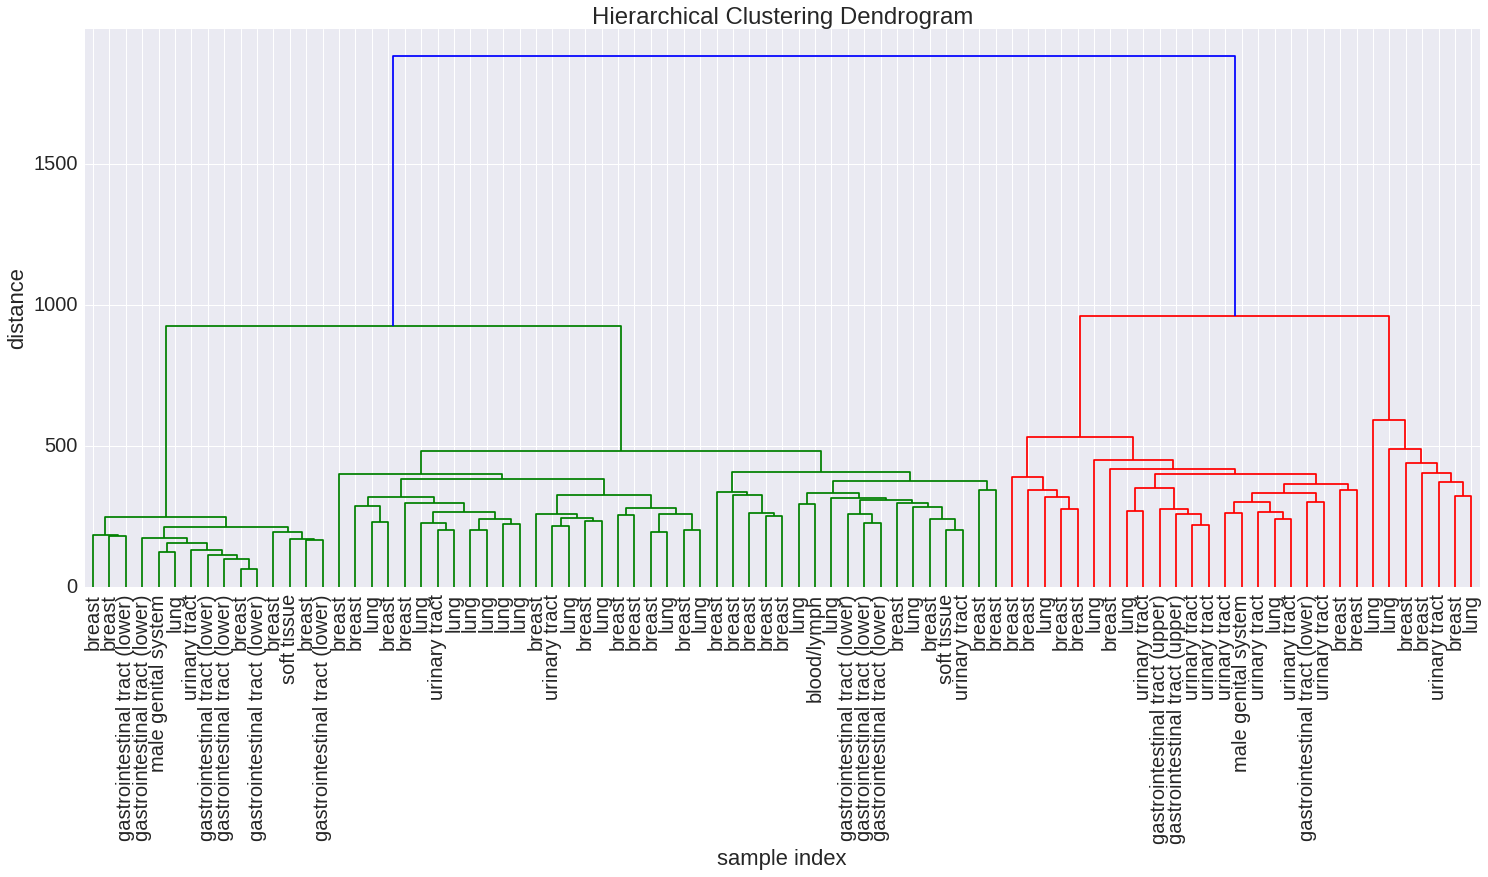

In [69]:
all_features = np.hstack([
    feature_dfs['min_cn'].values, 
    feature_dfs['max_cn'].values,
])

Z = sp.cluster.hierarchy.linkage(all_features, 'ward', 'euclidean')

fg, axes = plt.subplots(1, 1, figsize=(25, 10))
axes.set_title('Hierarchical Clustering Dendrogram')
axes.set_xlabel('sample index')
axes.set_ylabel('distance')

d = sp.cluster.hierarchy.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=20.,  # font size for the x axis labels
)
x = axes.xaxis.get_ticklabels()
for y in x:
    y.set_text(idx_to_cell_line_tissue[int(y.get_text())])
_ = axes.xaxis.set_ticklabels(x)

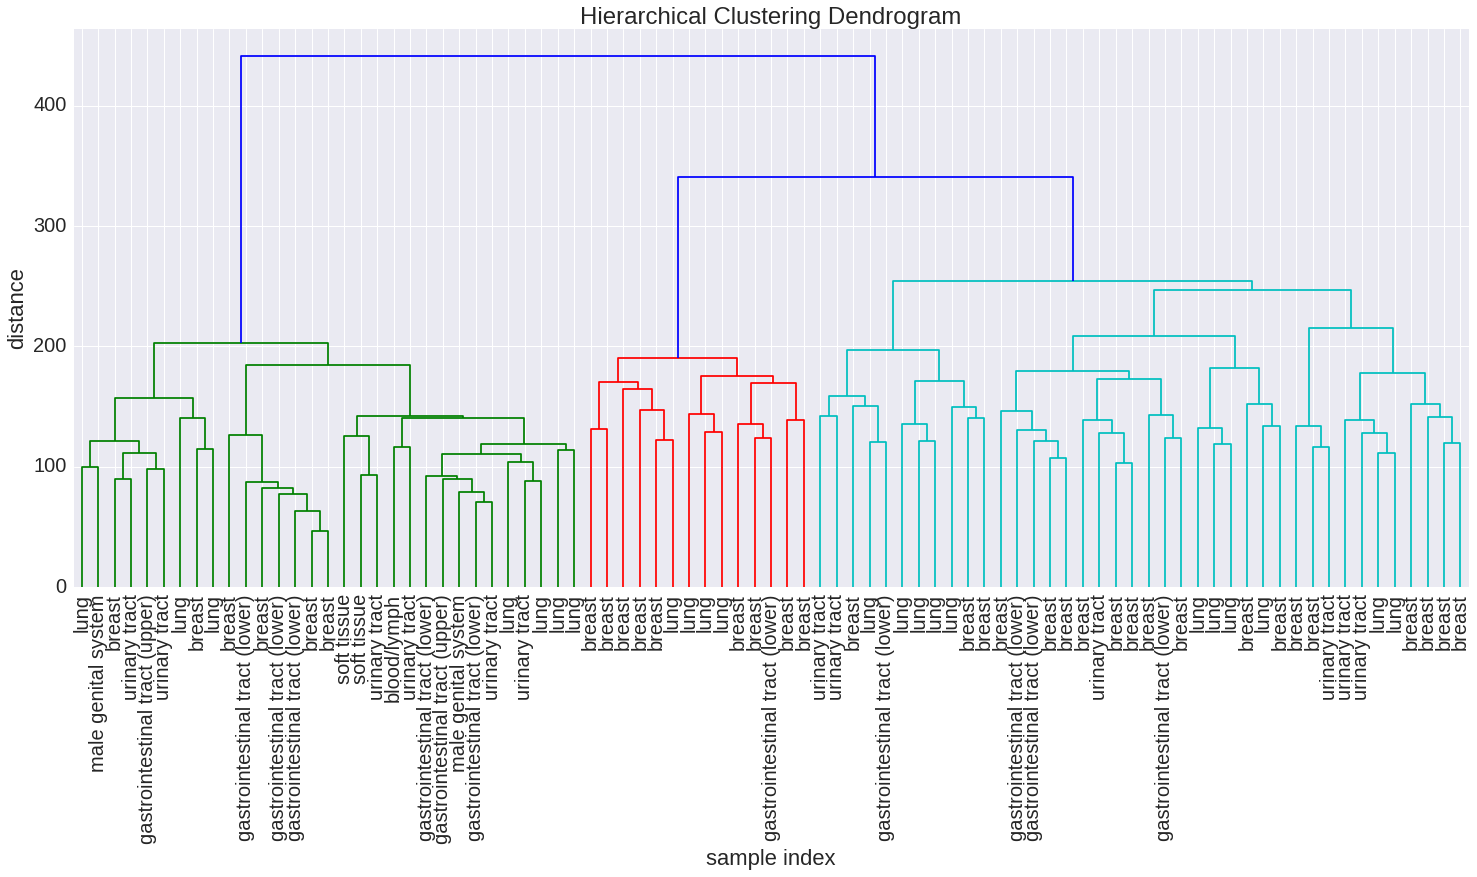

In [70]:
all_features = np.hstack([
    feature_dfs['zygosity_1'].values,
    feature_dfs['zygosity_2'].values,
])

Z = sp.cluster.hierarchy.linkage(all_features, 'ward', 'euclidean')

fg, axes = plt.subplots(1, 1, figsize=(25, 10))
axes.set_title('Hierarchical Clustering Dendrogram')
axes.set_xlabel('sample index')
axes.set_ylabel('distance')

d = sp.cluster.hierarchy.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=20.,  # font size for the x axis labels
)
x = axes.xaxis.get_ticklabels()
for y in x:
    y.set_text(idx_to_cell_line_tissue[int(y.get_text())])
_ = axes.xaxis.set_ticklabels(x)

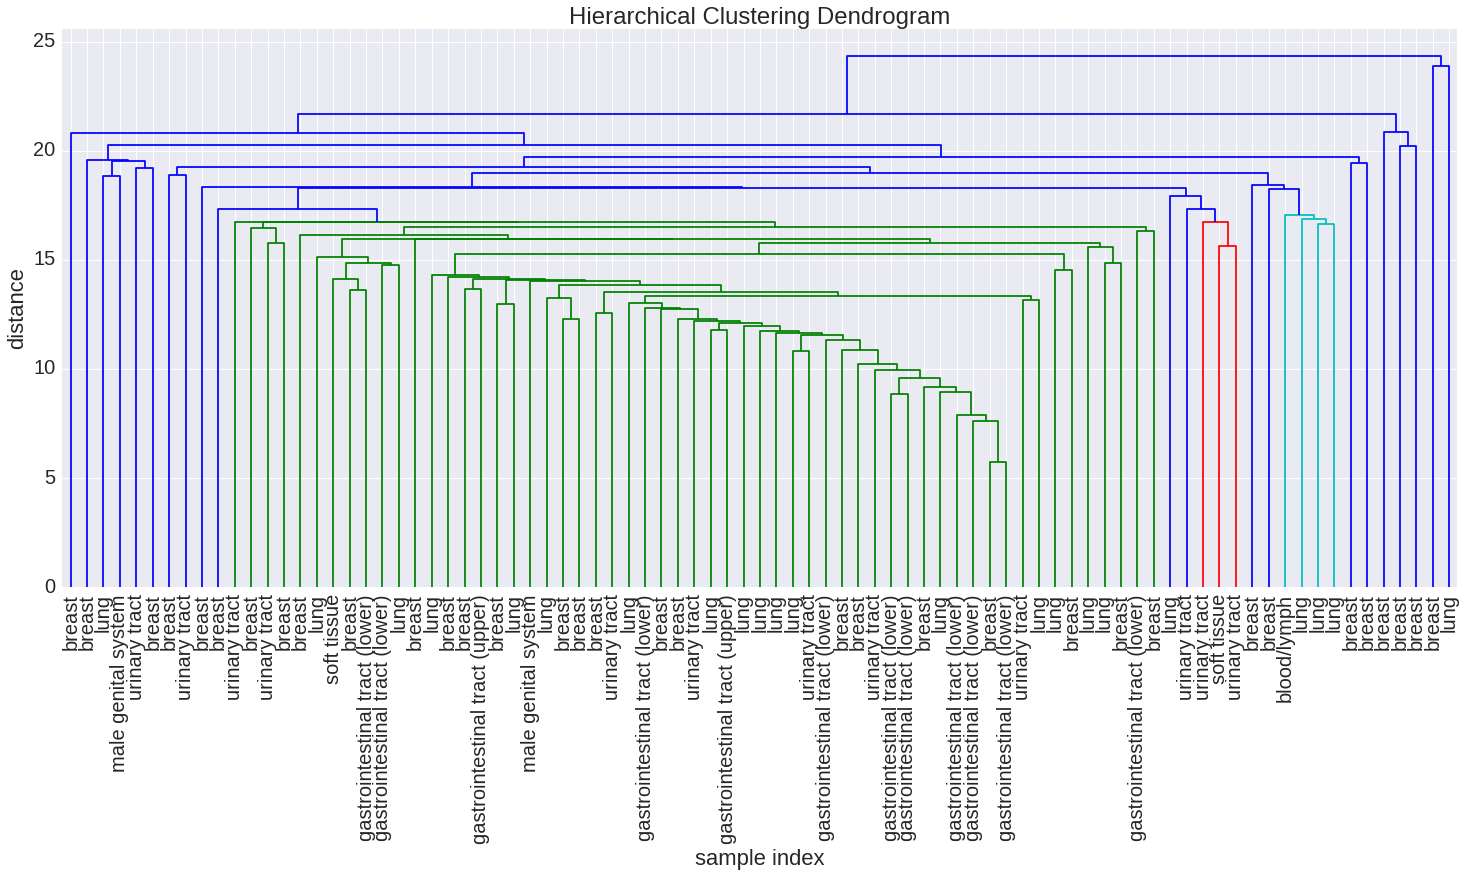

In [71]:
all_features = np.hstack([
    feature_dfs['disruption_status'].values
])

Z = sp.cluster.hierarchy.linkage(all_features, 'ward', 'euclidean')

fg, axes = plt.subplots(1, 1, figsize=(25, 10))
axes.set_title('Hierarchical Clustering Dendrogram')
axes.set_xlabel('sample index')
axes.set_ylabel('distance')

d = sp.cluster.hierarchy.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=20.,  # font size for the x axis labels
)
x = axes.xaxis.get_ticklabels()
for y in x:
    y.set_text(idx_to_cell_line_tissue[int(y.get_text())])
_ = axes.xaxis.set_ticklabels(x)